<a href="https://colab.research.google.com/github/Kulikov17/MLDS_CV/blob/main/cars_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Скачаем dataset из kaggle

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c hse-cars-competition

100% 1.82G/1.82G [01:07<00:00, 30.7MB/s]
100% 1.82G/1.82G [01:07<00:00, 29.1MB/s]


In [ ]:
!unzip hse-cars-competition.zip

In [1]:
import pandas as pd
import numpy as np

#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [2]:
train_ann = pd.read_csv('./annotation/train_ann.csv')

In [3]:
train_ann.sample(3)

,imname,class
1647,train/fd664f8ecc2b0618b9b9b53bdd616949.jpg,119
2056,train/50b2291d17b90b46ee8754649158f65a.jpg,172
1605,train/d99a77e89b8f08511856148cb5f55a83.jpg,66


In [ ]:
plot_data = train_ann.groupby(['class'])['class'].count().to_frame('count')

In [ ]:
plot_data['count'].min()

24

In [ ]:
plot_data['count'].max()

68

In [ ]:
plot_data['count'].mean()

41.48979591836735

<ipython-input-26-89dd7cb67e5e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='class', y='count', data=plot_data, palette='viridis')


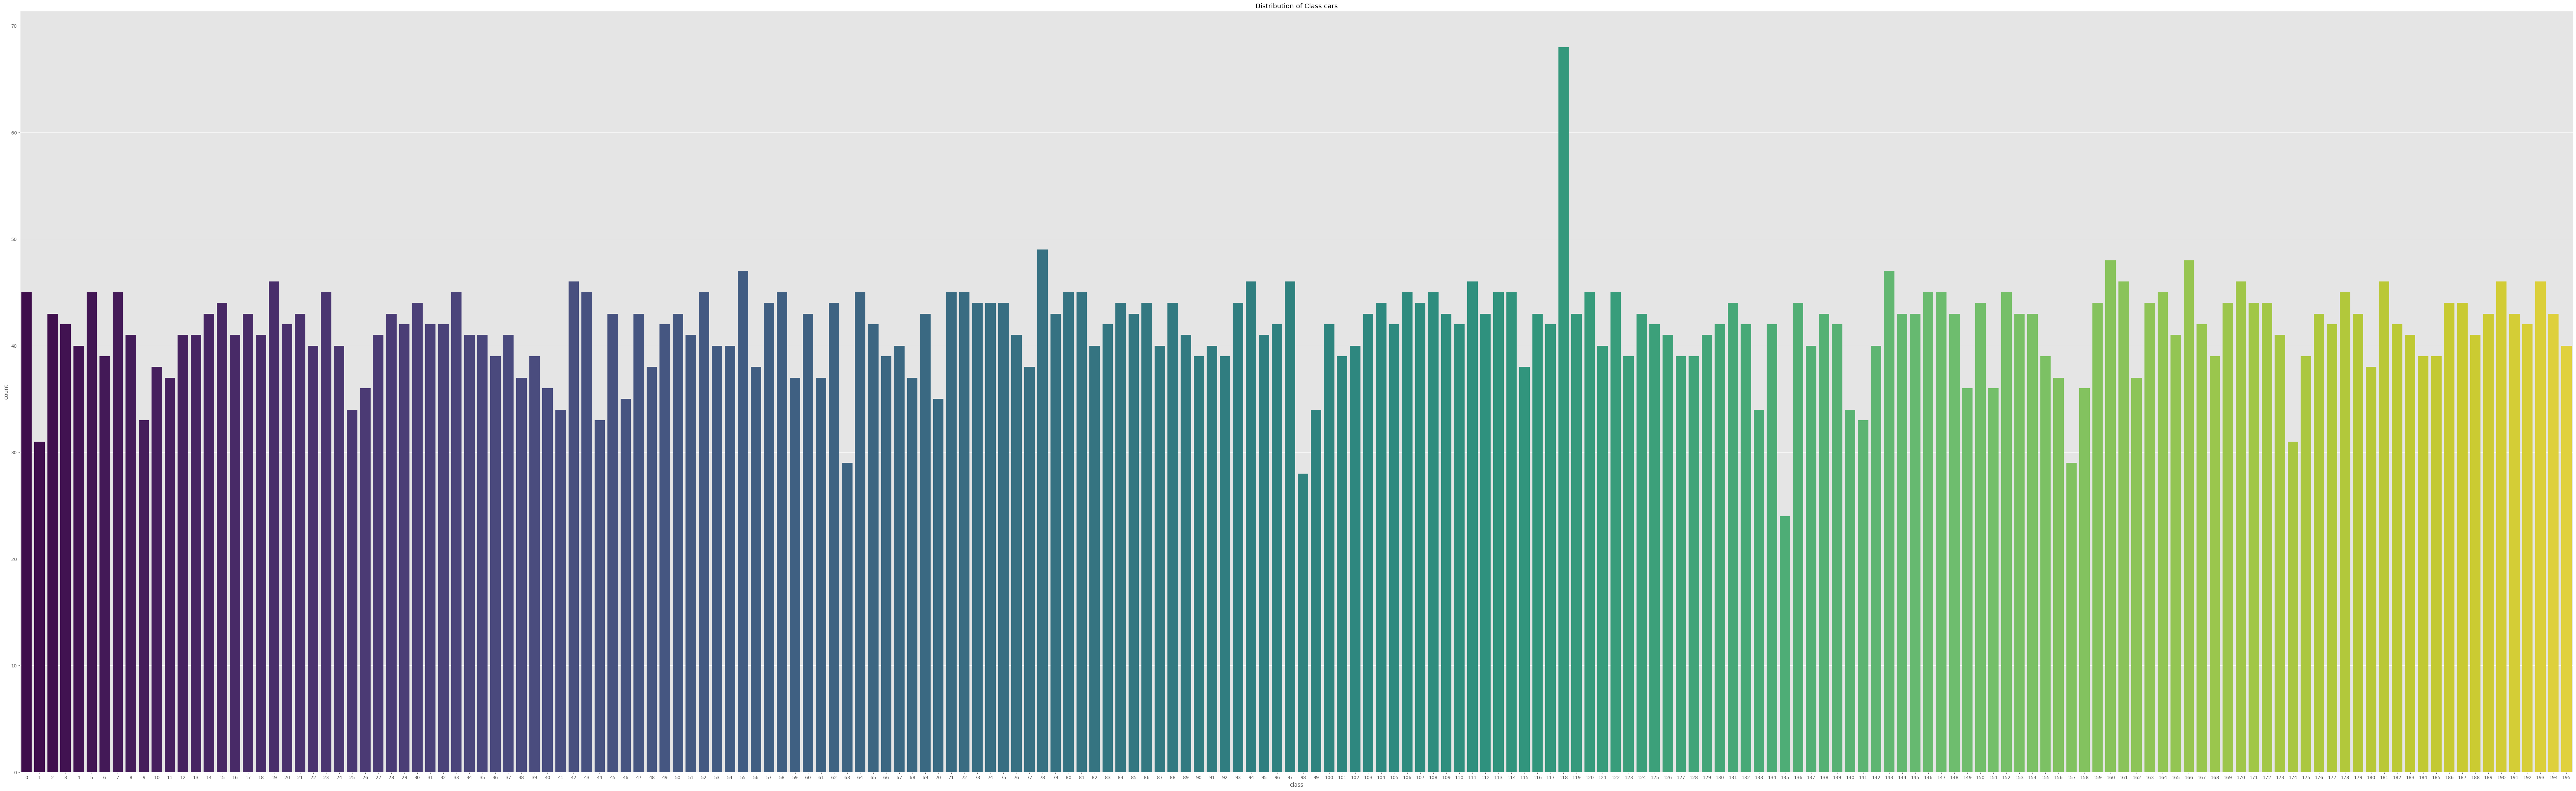

In [ ]:
plt.figure(figsize=(100, 30))

ax = sns.barplot(x='class', y='count', data=plot_data, palette='viridis')

plt.xlabel('class')
plt.ylabel('count')
plt.title('Distribution of Class cars')

plt.show()

Наблюдаем что классы несбалансированы, особенно класс 118

Идея попробовать сбалансировать датасет по минимальной шкале и обучить модель


In [4]:
def balanced_annotation(ann, max_count):
  class_dict = {}
  b_ann = pd.DataFrame()

  for i in range(len(ann)):
    impath, target = ann.loc[i]

    if target in class_dict:
      class_dict[target] += 1
    else:
      class_dict[target] = 1

    if class_dict[target] <= max_count:
      new_row = pd.DataFrame({'imname': impath, 'class': target}, index=[0])
      b_ann = pd.concat([b_ann.loc[:], new_row]).reset_index(drop=True)

  return b_ann


In [5]:
train_ann_b = balanced_annotation(train_ann, 10)

In [6]:
len(train_ann_b)

1960

In [7]:
def train_test_split_annotation(ann, max_count, percent):
  class_dict = {}
  train_ann = pd.DataFrame()
  test_ann = pd.DataFrame()

  for i in range(len(ann)):
    impath, target = ann.loc[i]

    if target in class_dict:
      class_dict[target] += 1
    else:
      class_dict[target] = 1

    new_row = pd.DataFrame({'imname': impath, 'class': target}, index=[0])

    if class_dict[target] / max_count < percent:
      train_ann = pd.concat([train_ann.loc[:], new_row]).reset_index(drop=True)
    else:
      test_ann = pd.concat([test_ann.loc[:], new_row]).reset_index(drop=True)


  return train_ann, test_ann


In [8]:
train_ann_b, val_ann_b = train_test_split_annotation(train_ann_b, 10, 0.8)

In [9]:
len(train_ann_b)

1372

In [10]:
len(val_ann_b)

588

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
from PIL import Image
from tqdm.auto import tqdm

In [12]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
device

device(type='cpu')

In [15]:
def get_train_transform(IMAGE_SIZE):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(35),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.RandomGrayscale(p=0.5),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.RandomPosterize(bits=2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return train_transform

# Validation transforms
def get_valid_transform(IMAGE_SIZE):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return valid_transform

In [16]:
class CarsDataset(Dataset):
    """Cars dataset."""

    def __init__(self, root_dir, imlist, transform=None):
        """
        Arguments:
            imlist(pandas DataFrame): DataFrame with columns file_name, class
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.imlist = imlist
        self.transform = transform

    def __len__(self):
        return len(self.imlist)

    def __getitem__(self, idx):
        impath, target = self.imlist.loc[idx]
        full_imname = os.path.join(self.root_dir, impath)

        if not os.path.exists(full_imname):
            print('No file ', full_imname)
            pass

        img = Image.open(full_imname).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, target

In [17]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

In [18]:
train_set = CarsDataset('./images',
                        train_ann_b,
                        transform=get_train_transform(IMAGE_SIZE))

val_set = CarsDataset('./images',
                      val_ann_b,
                      transform=get_valid_transform(IMAGE_SIZE))

In [19]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True,
                                           pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         pin_memory=True)

In [20]:
import torch
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')

def save_model(epoch, model, optimizer, criterion, acc):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"model_epoch_{epoch}_acc{acc}.pth")

def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


In [21]:
def train(model, loader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(loader), total=len(loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation.
        loss.backward()
        # Update the weights.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(loader.dataset))
    return epoch_loss, epoch_acc

In [22]:
def validate(model, loader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(loader.dataset))
    return epoch_loss, epoch_acc

In [23]:
# Learning_parameters.
lr = 0.001
epochs = 5

In [24]:
def build_model(pretrained=True, fine_tune=True, num_classes=196):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')

    model = models.efficientnet_v2_s(pretrained=pretrained)

    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False

    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)

    return model

In [25]:
import torch.nn.functional as F


def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss


def linear_combination(x, y, epsilon):
    return epsilon * x + (1 - epsilon) * y


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss / n, nll, self.epsilon)

In [26]:
# Load the model.
model = build_model(pretrained=True, fine_tune=True).to(device)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# Optimizer.
optimizer = optim.AdamW(model.parameters(), lr=lr)

# Loss function.
criterion = LabelSmoothingCrossEntropy()

[INFO]: Loading pre-trained weights


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Fine-tuning all layers...
20,428,564 total parameters.
20,428,564 training parameters.


In [ ]:
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_loader, criterion)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

    if len(valid_acc) == 1 or valid_epoch_acc >= max(valid_acc[:-1]):
        save_model(epoch, model, optimizer, criterion, valid_epoch_acc)


# Save the loss and accuracy plots.
save_plots(train_acc, valid_acc, train_loss, valid_loss)

print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 5
Training


  0%|          | 0/43 [00:00<?, ?it/s]